# Day 25 - Telling birds from airplanes: Learning from images

## A dataset of tiny images

### Dataset transforms

In [1]:
import torch
from torch import nn
from torchvision import datasets
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.empty_cache()

data_path = "./DLPT/data/"
cifar10 = datasets.CIFAR10(data_path, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

cifar10, cifar10_val

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./DLPT/data/
     Split: Train,
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./DLPT/data/
     Split: Test)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

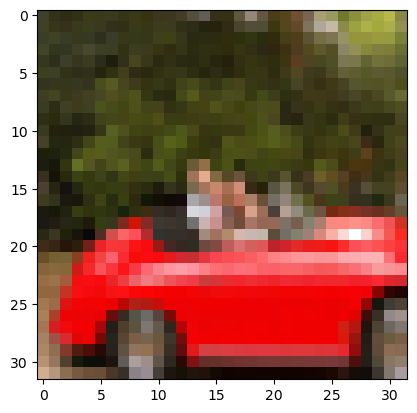

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.imshow(img)
plt.show()

* We can't feed a PIL image to our networks, so we have to transform it first
* Transforms can be passed to the dataset, in which case they will be applied whenever `__getitem__` is called

In [5]:
from torchvision import transforms

dir(transforms)[39]

'ToTensor'

* Oh, look! `ToTensor`
* This also takes care of moving channels around to conform to our $C\times H\times W$ convention

In [6]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [7]:
tensor_cifar10 = datasets.CIFAR10(data_path, transform=transforms.ToTensor())

In [8]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [9]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

* This also takes care of scaling the image's values into the $[0, 1]$ range

In [10]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

* We can see for ourselves that it is still the same image

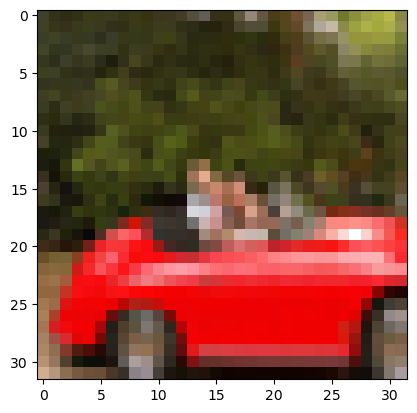

In [11]:
plt.imshow(img_t.permute(1, 2, 0)) # C x H x W -> H x W x C
plt.show()

### Normalizing data

* To help with training, we want to normalize our data to zero mean and unitary standard deviation
* We can do this for images by composing our transforms
* `transforms.Normalize` does this for us on a per channel basis

In [12]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [13]:
mean = imgs.view(3, -1).mean(dim=1).tolist()
mean

[0.4913996458053589, 0.48215845227241516, 0.44653093814849854]

In [14]:
std = imgs.view(3, -1).std(dim=1).tolist()
std

[0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

In [15]:
normalize = transforms.Normalize(mean, std)

In [16]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)

transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802377..2.1267893].


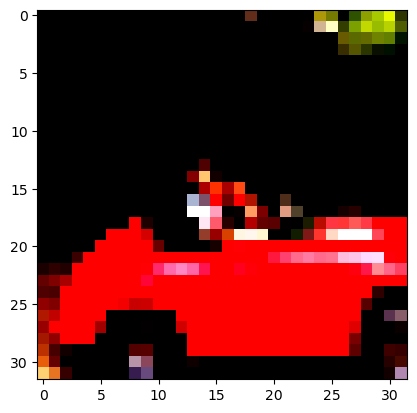

In [17]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

* Matplotlib cannot use this data anymore, as it has left the $[0, 1]$ range

## Distinguishing birds from airplanes

### Building the dataset

* We can filter the CIFAR-10 dataset to include only birds and airplanes

In [18]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in [0, 2]]

In [19]:
len(cifar2), len(cifar2_val)

(10000, 2000)

* As we don't know how to handle spatial relationships yet, we will flatten the images

In [20]:
import torch.nn as nn

n_out = 2
n_in = 3 * 32 * 32

model = nn.Sequential(
    nn.Linear(n_in, 512),
    nn.ReLU(),
    nn.Linear(512, n_out)
)

### Output of a classifier

* As demonstrated in the exercises of the last chapter, we need to use the proper loss function for a classifier
* The code below was not written while following the book

### Representing the output as probabilities

### Training the classifier

In [21]:
import numpy as np
from tqdm.auto import tqdm


def training_loop(n_epochs, optimizer, model, loss_fn, data_train, data_val, rep_freq=1000):
    train_losses = np.zeros(n_epochs)
    val_losses = np.zeros(n_epochs)
    val_accs = np.zeros(n_epochs)

    # Exponential weight factor
    alpha = 0.3
    
    for epoch in tqdm(range(1, n_epochs + 1), desc="Epochs"):
        # Initialize batch averages for each epoch
        batch_losses_train = []
        batch_losses_val = []
        batch_accs = []
        
        # Training phase
        for batch_imgs, batch_targets in data_train:
            batch_imgs = batch_imgs.to(device=device, non_blocking=True)
            batch_targets = batch_targets.to(device=device, non_blocking=True)
            batch_out = model(batch_imgs)
            loss_train = loss_fn(batch_out, batch_targets)
            batch_losses_train.append(loss_train.item())
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        # Validation phase
        with torch.no_grad():
            for val_imgs, val_targets in data_val:
                val_imgs = val_imgs.to(device=device, non_blocking=True)
                val_targets = val_targets.to(device=device, non_blocking=True)
                model.eval()
                val_out = model(val_imgs)
                loss_val = loss_fn(val_out, val_targets)
                batch_losses_val.append(loss_val.item())
                
                preds = val_out.argmax(dim=-1)
                targets = val_targets.to(device=device)
                total_correct = (targets == preds).sum()
                accuracy = total_correct / preds.shape[0]
                batch_accs.append(accuracy.item())
                model.train()
        
        # Calculate average metrics for this epoch
        epoch_train_loss = np.mean(batch_losses_train)
        epoch_val_loss = np.mean(batch_losses_val)
        epoch_val_acc = np.mean(batch_accs)
        
        # Store metrics with exponential weighting
        if epoch == 1:
            # First epoch: use raw values
            train_losses[epoch-1] = epoch_train_loss
            val_losses[epoch-1] = epoch_val_loss
            val_accs[epoch-1] = epoch_val_acc
        else:
            # Subsequent epochs: use exponential weighted average
            train_losses[epoch-1] = (1 - alpha) * train_losses[epoch-2] + alpha * epoch_train_loss
            val_losses[epoch-1] = (1 - alpha) * val_losses[epoch-2] + alpha * epoch_val_loss
            val_accs[epoch-1] = (1 - alpha) * val_accs[epoch-2] + alpha * epoch_val_acc

        if epoch == 1 or epoch == n_epochs or epoch % rep_freq == 0:
            print(f"Epoch {epoch}, Training loss {train_losses[epoch-1]:.4f},"
                  f" Validation loss {val_losses[epoch-1]:.4f},"
                  f" Validation accuracy: {val_accs[epoch-1] * 100:.2f}%")

    return train_losses, val_losses, val_accs

In [22]:
from torch.utils.data import TensorDataset, DataLoader

samples_train, targets_train = [], []
for img, label in cifar2:
    samples_train.append(img)
    targets_train.append(label)
    
samples_val, targets_val = [], []
for img, label in cifar2_val:
    samples_val.append(img)
    targets_val.append(label)

samples_train = torch.stack(samples_train)
targets_train = torch.tensor(targets_train)
samples_val = torch.stack(samples_val)
targets_val = torch.tensor(targets_val)

train_dataset = TensorDataset(samples_train, targets_train)
val_dataset = TensorDataset(samples_val, targets_val)

batch_size = 384
loader_train = DataLoader(
    train_dataset,
    batch_size,
    shuffle=True,
    pin_memory=True,
)
loader_val = DataLoader(val_dataset, samples_val.shape[0], shuffle=False, pin_memory=True)

In [23]:
from torch import optim, nn

n_out = 2

model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
    nn.Conv2d(32, 64, 3, padding=1),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
    nn.Conv2d(64, 128, 3, padding=1),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # 8x8 -> 4x4
    nn.Flatten(),
    nn.Linear(2048, 512),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(512, n_out)
).to(device=device)

model = torch.compile(model)
if device == "cuda":
    torch.set_float32_matmul_precision('high')

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

In [24]:
print(f"{sum(p.numel() for p in model.parameters()):,}")

1,143,362


In [25]:
tl, vl, va = training_loop(
    n_epochs = 150,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    data_train = loader_train,
    data_val = loader_val,
    rep_freq=25,
)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1, Training loss 0.5803, Validation loss 0.5555, Validation accuracy: 81.50%
Epoch 25, Training loss 0.1834, Validation loss 0.2834, Validation accuracy: 90.66%
Epoch 50, Training loss 0.1048, Validation loss 0.2128, Validation accuracy: 92.57%
Epoch 75, Training loss 0.0711, Validation loss 0.1889, Validation accuracy: 92.84%
Epoch 100, Training loss 0.0588, Validation loss 0.1763, Validation accuracy: 93.33%
Epoch 125, Training loss 0.0524, Validation loss 0.1725, Validation accuracy: 93.17%
Epoch 150, Training loss 0.0522, Validation loss 0.1738, Validation accuracy: 93.05%


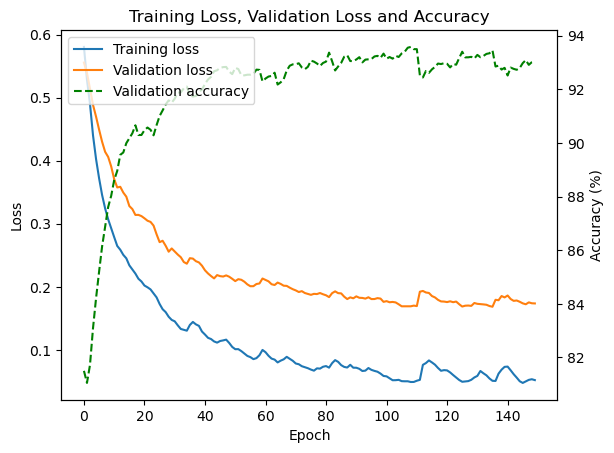

In [26]:
fig, ax1 = plt.subplots()

ax1.plot(tl, label="Training loss")
ax1.plot(vl, label="Validation loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2 = ax1.twinx()

color = "tab:green"
ax2.plot(va * 100, 'g--', label="Validation accuracy")
ax2.set_ylabel("Accuracy (%)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Training Loss, Validation Loss and Accuracy")
plt.show()

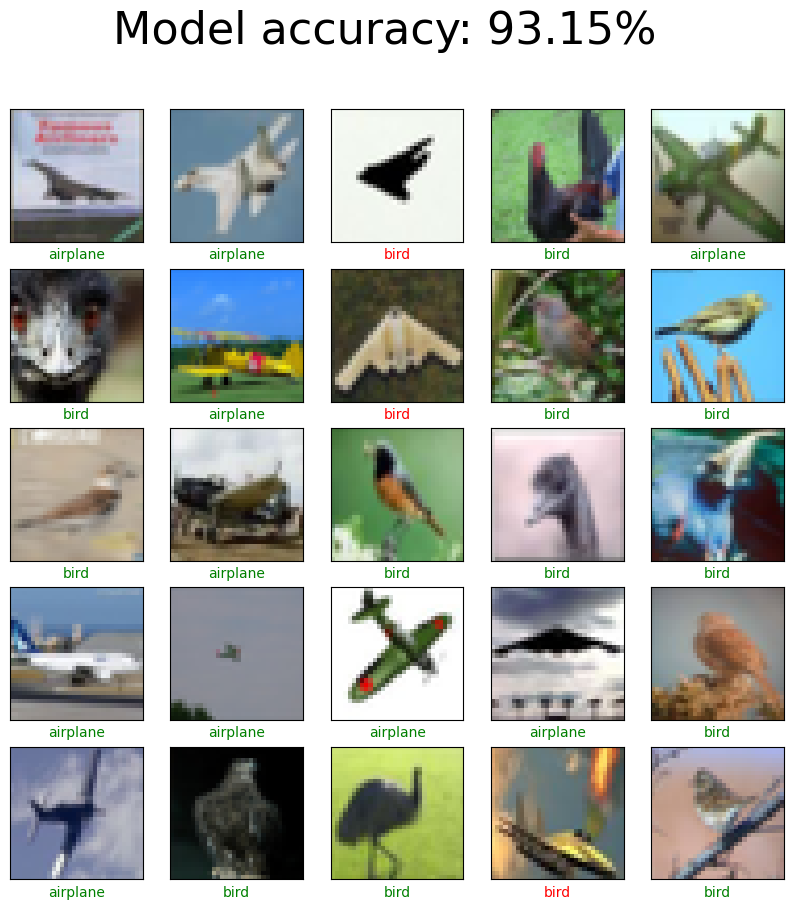

In [27]:
with torch.no_grad():
    model.eval()
    preds = model(samples_val.to(device=device)).argmax(dim=-1)

targets = targets_val.to(device=device)

cifar2_val_imgs = [img
              for img, label in cifar10_val
              if label in [0, 2]]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
total_correct = (targets == preds).sum()
accuracy = total_correct / preds.shape[0]
fig.suptitle(f"Model accuracy: {accuracy * 100:.2f}%", fontsize=32)

for i in range(25):
    r = i // 5
    c = i % 5
    img = cifar2_val_imgs[i]
    axes[r, c].imshow(img)
    correct = (preds[i] == targets[i]).item()
    color = "green" if correct else "red"
    axes[r, c].set_xlabel(class_names[preds[i]], color=color)
    
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

plt.show()